In [1]:
import h5py
import pickle
import random
import pandas as pd
import numpy as np
from j2v import mag
from j2v import w2v
from j2v import predict
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict, Counter
from matplotlib.ticker import FormatStrFormatter

Using Theano backend.


In [2]:
model = w2v.load_j2v(mag.get_path('100feat_50minwords_10context_2016'))


model shape is: (20835, 100) 



In [3]:
mapping = mag.load_map_jid_discipline('journal_discipline_map.csv')

14113 journals in MAG's Journal.txt were matched to UCSD data, and 29 of them are interdisciplinary journals in UCSD catelog.


In [4]:
def evaluate(algo, data, output_dict = False):
    data_feat, y_true = predict.get_feat_label(data)
    y_pred = algo.predict(data_feat)
    y_pred = y_pred.tolist()
    y_true = y_true.tolist()
    labels = list(set(y_true))
    confux = metrics.confusion_matrix(y_true, y_pred)
    report = metrics.classification_report(y_true, y_pred, output_dict=output_dict)
    if output_dict:
        return report
    else:
        # print('\nConfusion matrix:\n\n{}'.format(confux))
        print('\nReport:\n\n{}'.format(report))

In [5]:
ks = [3, 5, 10, 15, 20, 25]
CIs = {'90': 1.645, '95': 1.96, '99': 2.576}

### j2v

In [6]:
data, new_data = predict.prepare_data(model, mapping)

data length: 12780, new_data length: 8055


In [7]:
del new_data

In [8]:
data = data.loc[data.disc_name!='Interdiscipline']
data = data.sample(frac = 1.0, random_state = 50)
data.index = range(len(data))

In [10]:
train_size = int(len(data) * 0.8)

In [11]:
len(data)

12751

In [12]:
data.head()

,jid,vec,disc_name,disc_id
0,064E8C6E,"[0.1474838, -0.02644856, 0.050521947, -0.17488...","Chemical, Mechanical, & Civil Engineering",4
1,0409A0BE,"[-0.026871508, -0.0149207935, -0.14497748, 0.0...",Social Sciences,13
2,0A4EC460,"[0.12223036, -0.04064537, 0.13387638, 0.091028...",Biology,1
3,073DD5CA,"[0.086067885, -0.10123753, 0.032514945, -0.231...",Health Professionals,12
4,035539A0,"[-0.011840087, -0.16105092, 0.028254243, -0.09...","Chemical, Mechanical, & Civil Engineering",4


In [13]:
predict.base_line(data)

		12751 known data distribution (baseline prediction)

                                      Biology:	1051 ( 8.24/100)
                                Biotechnology:	 238 ( 1.87/100)
                               Brain Research:	 738 ( 5.79/100)
    Chemical, Mechanical, & Civil Engineering:	1016 ( 7.97/100)
                                    Chemistry:	 640 ( 5.02/100)
                               Earth Sciences:	 489 ( 3.83/100)
    Electrical Engineering & Computer Science:	 778 ( 6.10/100)
                         Health Professionals:	1387 (10.88/100)
                                   Humanities:	 654 ( 5.13/100)
                          Infectious Diseases:	 660 ( 5.18/100)
                               Math & Physics:	 738 ( 5.79/100)
                          Medical Specialties:	1650 (12.94/100)
                              Social Sciences:	2712 (21.27/100)


In [15]:
def knn_cv(data, ks):
    X, Y = predict.get_feat_label(data)
    results = []
    for k in ks:
        algo = predict.algorithm(model = 'knn', n_neighbors = k)
        cv_results = cross_val_score(algo, X, Y, cv=5, scoring='accuracy')
        results.append(cv_results)
        msg = "k = %d: mean accuracy on test is %f; std is (%f)" % (k, cv_results.mean(), cv_results.std())
        print(msg)
    return results

In [29]:
results = knn_cv(data[:train_size], ks)

k = 3: mean accuracy on test is 0.824016; std is (0.008139)
k = 5: mean accuracy on test is 0.832442; std is (0.008614)
k = 10: mean accuracy on test is 0.828913; std is (0.007690)
k = 15: mean accuracy on test is 0.825192; std is (0.007109)
k = 20: mean accuracy on test is 0.820290; std is (0.006656)
k = 25: mean accuracy on test is 0.814309; std is (0.004320)


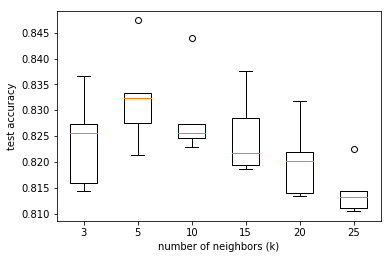

In [32]:
fig = plt.figure(figsize = (6, 4))
fig.subplots_adjust(left = 0.15, bottom = 0.15)
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(ks)
ax.set_xlabel('number of neighbors (k)')
ax.set_ylabel('test accuracy')
# ax.set_title('10-fold cross validation for k in KNN')
plt.show()
fig.savefig('knn-cv.pdf', dpi = 300)

In [ ]:
# train on all training data.
# algo = predict.algorithm(model = 'lr', C = 15)
# algo = predict.algorithm(model = 'rf', n_estimators= 18)

In [15]:
train_feat, train_y = predict.get_feat_label(data[:train_size])

In [49]:
ks = [3, 5, 10, 15, 20, 25]
for k in ks:
    algo = predict.algorithm(model = 'knn', n_neighbors = k)
    algo = algo.fit(train_feat, train_y)
    evaluate(algo, data[train_size:])

training knn model...

Report:

                                           precision    recall  f1-score   support

                                  Biology       0.81      0.89      0.84       211
                            Biotechnology       0.67      0.60      0.63        43
                           Brain Research       0.73      0.82      0.77       144
Chemical, Mechanical, & Civil Engineering       0.80      0.84      0.82       189
                                Chemistry       0.79      0.81      0.80       144
                           Earth Sciences       0.86      0.82      0.84        95
Electrical Engineering & Computer Science       0.81      0.86      0.83       152
                     Health Professionals       0.82      0.73      0.77       279
                               Humanities       0.86      0.83      0.84       136
                      Infectious Diseases       0.73      0.65      0.69       139
                           Math & Physics       0.89  

In [21]:
# predict.predict_to_file(algo, new_data, 'pred_disc_name.csv')

### Citation matrix

In [16]:
# see `get_citation_vec_model.ipynb`

h5f = h5py.File(mag.get_path('venue_citation_matrix.h5'),'r')
matrix = h5f['matrix'][:]
h5f.close()

In [34]:
with open(mag.get_path('venue_citation_matrix_index.pickle'), 'rb') as file:
    col_index2vid, vid2col_index = pickle.load(file)

In [18]:
data_citation = data.copy()

In [19]:
data_citation['vec'] = data_citation['jid'].apply(lambda jid: matrix[vid2col_index[jid], :])

In [20]:
data_citation.shape

(12751, 4)

In [21]:
del matrix

In [22]:
data_citation.head()

,jid,vec,disc_name,disc_id
0,064E8C6E,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","Chemical, Mechanical, & Civil Engineering",4
1,0409A0BE,"[0.0, 0.0, 0.0, 0.0, 7.579777154551656e-05, 0....",Social Sciences,13
2,0A4EC460,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Biology,1
3,073DD5CA,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Health Professionals,12
4,035539A0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","Chemical, Mechanical, & Civil Engineering",4


In [134]:
train_feat, train_y = predict.get_feat_label(data_citation[:train_size])

In [139]:
ks = [3, 5, 10, 15, 20, 25]
for k in ks:
    algo = predict.algorithm(model = 'knn', n_neighbors = k)
    algo = algo.fit(train_feat, train_y)
    evaluate(algo, data_citation[train_size:])

training knn model...

Report:

                                           precision    recall  f1-score   support

                                  Biology       0.80      0.87      0.83       214
                            Biotechnology       0.19      0.51      0.28        45
                           Brain Research       0.74      0.83      0.78       151
Chemical, Mechanical, & Civil Engineering       0.70      0.70      0.70       178
                                Chemistry       0.77      0.75      0.76       131
                           Earth Sciences       0.76      0.80      0.78        85
Electrical Engineering & Computer Science       0.81      0.78      0.80       147
                     Health Professionals       0.78      0.70      0.74       299
                               Humanities       0.79      0.58      0.67       130
                      Infectious Diseases       0.77      0.73      0.75       140
                           Math & Physics       0.87  

### Jaccard similarity matrix

In [9]:
# see `journal_pair_similarity.ipynb`

h5f = h5py.File(mag.get_path('jac_simi_matrix.h5'),'r')
jac = h5f['jac'][:]
h5f.close()

In [10]:
jac.shape

(24020, 24020)

In [11]:
with open(mag.get_path('venue_citation_matrix_index.pickle'), 'rb') as file:
    col_index2vid, vid2col_index = pickle.load(file)

In [12]:
data_jac = data.copy()

In [13]:
data_jac['vec'] = data_jac['jid'].apply(lambda jid: jac[vid2col_index[jid], :])

In [14]:
data_jac.shape

(12751, 4)

In [15]:
del jac

In [16]:
data_jac.head()

,jid,vec,disc_name,disc_id
0,064E8C6E,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...","Chemical, Mechanical, & Civil Engineering",4
1,0409A0BE,"[0.0, 0.0, 0.0, 0.0, 5.4130128829706606e-05, 0...",Social Sciences,13
2,0A4EC460,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Biology,1
3,073DD5CA,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Health Professionals,12
4,035539A0,"[0.0, 0.0, 0.0, 0.0, 4.385580212262082e-05, 0....","Chemical, Mechanical, & Civil Engineering",4


### 5 folds validation

In [17]:
n_folds = 5
kfold = KFold(n_splits=n_folds, random_state=7)

In [24]:
cv_results = {}

In [18]:
def knn_cv_report(df, ks, kfold):
    results = defaultdict(list)
    for train_index, test_index in kfold.split(df):
        train_feat, train_y = predict.get_feat_label(df.loc[train_index])
        for k in ks:
            algo = predict.algorithm(model = 'knn', n_neighbors = k)
            algo = algo.fit(train_feat, train_y)
            report = evaluate(algo, df.loc[test_index], output_dict=True)
            results[k].append(report)
    return results

In [28]:
cv_results['j2v'] = knn_cv_report(data, ks, kfold)

training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...


In [ ]:
cv_results['citation'] = knn_cv_report(data_citation, ks, kfold)

training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...


In [ ]:
cv_results['jac'] = knn_cv_report(data_jac, ks, kfold)

training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...
training knn model...


In [36]:
jid_disc = pd.Series(data.disc_name.values, index=data.jid).to_dict()

In [37]:
# weighted out-degree

# to make a fair comparison, we assume we don't know the discipline category for test journals, 
# thus edges to test journals are excluded.

vote_results = []

for train_index, test_index in kfold.split(data_citation):
    test_feat = np.array(data_citation.loc[test_index]['vec'].tolist())
    train_jids = data_citation.loc[train_index]['jid'].tolist()
    index_to_train_jids = {i: jid for i, jid in enumerate(train_jids)}
    train_jids_ixs = [vid2col_index[jid] for jid in train_jids]
    test_feat = test_feat[:, train_jids_ixs]
    pred_index = np.argmax(test_feat, axis=1)
    y_pred = [jid_disc[index_to_train_jids[ix]] for ix in pred_index]
    y_true = data_citation.loc[test_index]['disc_name']
    report = metrics.classification_report(y_true, y_pred, output_dict=True)
    vote_results.append(report)

In [58]:
# weighted in-degree
vote_results = []

for train_index, test_index in kfold.split(data_citation):
    test_feat = np.array(data_citation.loc[test_index]['vec'].tolist())
    train_jids = data_citation.loc[train_index]['jid'].tolist()
    index_to_train_jids = {i: jid for i, jid in enumerate(train_jids)}
    # the citation matrix contains both in- and out-degree matrix.
    train_jids_ixs = [vid2col_index[jid]+len(vid2col_index) for jid in train_jids]
    test_feat = test_feat[:, train_jids_ixs]
    pred_index = np.argmax(test_feat, axis=1)
    y_pred = [jid_disc[index_to_train_jids[ix]] for ix in pred_index]
    y_true = data_citation.loc[test_index]['disc_name']
    report = metrics.classification_report(y_true, y_pred, output_dict=True)
    vote_results.append(report)

In [60]:
# sum of weighted out-degree and weighted in-degree
vote_results = []

for train_index, test_index in kfold.split(data_citation):
    test_feat = np.array(data_citation.loc[test_index]['vec'].tolist())
    train_jids = data_citation.loc[train_index]['jid'].tolist()
    index_to_train_jids = {i: jid for i, jid in enumerate(train_jids)}
    train_jids_ixs_out = [vid2col_index[jid] for jid in train_jids]
    train_jids_ixs_in = [vid2col_index[jid]+len(vid2col_index) for jid in train_jids]
    test_feat = np.add(test_feat[:, train_jids_ixs_out], test_feat[:, train_jids_ixs_in])
    pred_index = np.argmax(test_feat, axis=1)
    y_pred = [jid_disc[index_to_train_jids[ix]] for ix in pred_index]
    y_true = data_citation.loc[test_index]['disc_name']
    report = metrics.classification_report(y_true, y_pred, output_dict=True)
    vote_results.append(report)

In [66]:
# to reconstruct total in and out degrees.

with open(mag.get_path('venue_citation_degrees.pickle'), 'rb') as file:
    vid_out_sum, vid_in_sum = pickle.load(file)

In [73]:
# undirected (sum of in and out)
vote_results = []

for train_index, test_index in kfold.split(data_citation):
    test_jids = data_citation.loc[test_index]['jid'].tolist()
    test_jids_out_deg = np.array([vid_out_sum[jid] for jid in test_jids])
    test_jids_in_deg = np.array([vid_in_sum[jid] for jid in test_jids])
    test_feat = np.array(data_citation.loc[test_index]['vec'].tolist())
    # data_citation contains weighted in and out degrees.
    # now we reconstruct the in and out degree counts for test journals.
    test_feat[:, :len(vid2col_index)] = np.multiply(test_feat[:, :len(vid2col_index)], test_jids_out_deg[:, np.newaxis])
    test_feat[:, len(vid2col_index):] = np.multiply(test_feat[:, len(vid2col_index):], test_jids_in_deg[:, np.newaxis])
    train_jids = data_citation.loc[train_index]['jid'].tolist()
    index_to_train_jids = {i: jid for i, jid in enumerate(train_jids)}
    train_jids_ixs_out = [vid2col_index[jid] for jid in train_jids]
    train_jids_ixs_in = [vid2col_index[jid]+len(vid2col_index) for jid in train_jids]
    test_feat = np.add(test_feat[:, train_jids_ixs_out], test_feat[:, train_jids_ixs_in])
    pred_index = np.argmax(test_feat, axis=1)
    y_pred = [jid_disc[index_to_train_jids[ix]] for ix in pred_index]
    y_true = data_citation.loc[test_index]['disc_name']
    report = metrics.classification_report(y_true, y_pred, output_dict=True)
    vote_results.append(report)

In [75]:
cv_results['vote'] = vote_results

In [40]:
# with open(mag.DATA_ROOT+'pred_disc_cv_results.pickle', 'wb') as file:
#     pickle.dump(cv_results, file)

In [19]:
with open(mag.DATA_ROOT+'pred_disc_cv_results.pickle', 'rb') as file:
    cv_results = pickle.load(file)

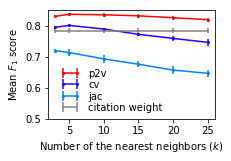

In [48]:
feats = ['j2v', 'citation', 'vote', 'jac']
labels_dict = {'vote': 'citation weight', 'citation': 'cv', 'j2v': 'p2v', 'jac': 'jac'}

cols = ['#ff0000', '#2500ff', '_', '#0080ff']
metric = 'f1-score' # 'precision'

fig, ax = plt.subplots(figsize = (3, 2))

for feat, col in zip(feats, cols):
    if feat != 'vote':
        ys = []
        stds = []
        for k in ks:
            accs = []
            for report in cv_results[feat][k]:
                acc = report['weighted avg'][metric]
                accs.append(acc)
            ys.append(np.mean(accs))
            stds.append(np.std(accs))
        ax.errorbar(ks, ys, yerr=CIs['95']*(stds/np.sqrt(n_folds)), color=col, marker='o', markersize=2, linewidth=1.5, label=labels_dict[feat], fillstyle='full')
    else:
        accs = []
        for report in cv_results[feat]:
            acc = report['weighted avg'][metric]
            accs.append(acc)
        ys = [np.mean(accs)] * len(ks)
        stds = [np.std(accs)] * len(ks)
        ax.errorbar(ks, ys, yerr=CIs['95']*(stds/np.sqrt(n_folds)), color='gray', marker='o', markersize=0, linewidth=1.5, label=labels_dict[feat], fillstyle='full')
        
handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1], handles[3], handles[2]]
labels = [labels[0], labels[1], labels[3], labels[2]]
legend = ax.legend(handles, labels, loc=[0.05, 0.02], numpoints=2, labelspacing = 0.15, shadow=False, frameon = False)

ax.set_xticklabels(ks)
ax.set_ylim([0.50, 0.85])
# ax.set_yticks([0.55, 0.65, 0.75, 0.85])
ax.set_xlabel(r'Number of the nearest neighbors ($k$)')
ax.set_ylabel(r'Mean $F_1$ score')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.set_ylabel('mean accuracy')
# ax.set_title('10-fold cross validation for k in KNN')
plt.show()
fig.savefig('knn-cv-compare-undirected.pdf', bbox_inches='tight', pad_inches=0)